In [1]:
import pandas as pd
import yfinance as yf
import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import plotly.express as px

In [2]:
data = yf.download("BTC-USD", start=(dt.datetime.today()-dt.timedelta(days=362*5)).strftime("%Y-%m-%d"))


[*********************100%***********************]  1 of 1 completed


In [3]:
data = data[["Adj Close"]]

In [4]:
px.line(data, labels={"value": "Price", "index": "Date"})

In [55]:
def df_to_windowed_df(dataframe, n=3):
    matrix = []
    for i in range(n+1, len(data)+1):
        if i == len(data):
            matrix.append([data.index[i-1]]+data["Adj Close"][i-4:i].values.tolist())
        else:
            matrix.append([data.index[i]]+data["Adj Close"][i-4:i].values.tolist())
    return pd.DataFrame(matrix, columns=["Date", "t-3", "t-2", "t-1", "t"])

In [56]:
windowed_df = df_to_windowed_df(data)

In [57]:
def windowed_df_to_date_X_y(windowed_dataframe):
  df_as_np = windowed_dataframe.to_numpy()

  dates = df_as_np[:, 0]

  middle_matrix = df_as_np[:, 1:-1]
  X = middle_matrix.reshape((len(dates), middle_matrix.shape[1], 1))

  Y = df_as_np[:, -1]

  return dates, X.astype(np.float32), Y.astype(np.float32)

dates, X, y = windowed_df_to_date_X_y(windowed_df)

dates.shape, X.shape, y.shape

((1808,), (1808, 3, 1), (1808,))

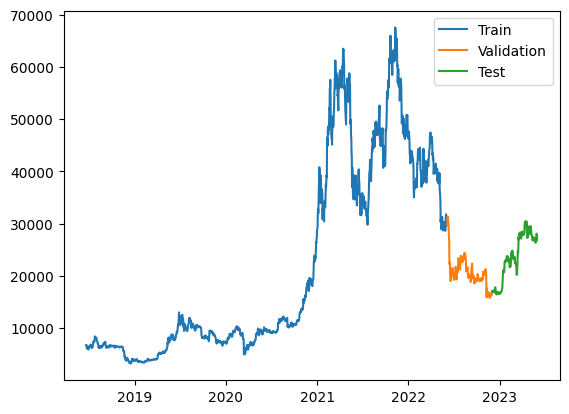

In [128]:
q_80 = int(len(dates) * .8)
q_90 = int(len(dates) * .9)

dates_train, X_train, y_train = dates[:q_80], X[:q_80], y[:q_80]

dates_val, X_val, y_val = dates[q_80:q_90], X[q_80:q_90], y[q_80:q_90]
dates_test, X_test, y_test = dates[q_90:], X[q_90:], y[q_90:]

fig = plt.figure()
plt.plot(dates_train, y_train)
plt.plot(dates_val, y_val)
plt.plot(dates_test, y_test)

plt.legend(['Train', 'Validation', 'Test'])

In [67]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import layers

model = Sequential([layers.Input((3, 1)),
                    layers.LSTM(50, activation='relu', return_sequences=True),
                    layers.Dropout(0.2),
                    layers.LSTM(100, activation='relu', return_sequences=False),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(32, activation='relu'),
                    layers.Dense(1)])

model.compile(loss='mse', 
              optimizer=Adam(learning_rate=0.007),
              metrics=['mean_absolute_error'])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100)

Epoch 1/100
46/46 [==============================] - 4s 14ms/step - loss: 118058936.0000 - mean_absolute_error: 5069.5107 - val_loss: 12791160.0000 - val_mean_absolute_error: 3442.0586
Epoch 2/100
46/46 [==============================] - 0s 7ms/step - loss: 4004446.2500 - mean_absolute_error: 1155.7430 - val_loss: 7757348.0000 - val_mean_absolute_error: 2639.4436
Epoch 3/100
46/46 [==============================] - 0s 7ms/step - loss: 4451114.5000 - mean_absolute_error: 1271.4829 - val_loss: 20252282.0000 - val_mean_absolute_error: 4367.4116
Epoch 4/100
46/46 [==============================] - 0s 8ms/step - loss: 3374590.0000 - mean_absolute_error: 1083.6359 - val_loss: 15567360.0000 - val_mean_absolute_error: 3809.6436
Epoch 5/100
46/46 [==============================] - 0s 6ms/step - loss: 4347536.5000 - mean_absolute_error: 1231.0201 - val_loss: 13412680.0000 - val_mean_absolute_error: 3528.2231
Epoch 6/100
46/46 [==============================] - 0s 6ms/step - loss: 6271644.5000 - 

46/46 [==============================] - 0s 4ms/step


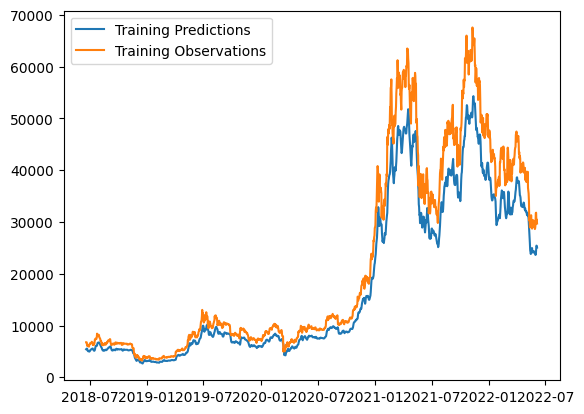

In [68]:
train_predictions = model.predict(X_train).flatten()

plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.legend(['Training Predictions', 'Training Observations'])

6/6 [==============================] - 0s 2ms/step


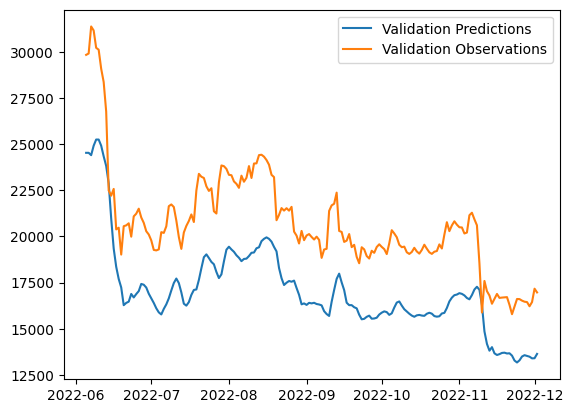

In [69]:
val_predictions = model.predict(X_val).flatten()

plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.legend(['Validation Predictions', 'Validation Observations'])

6/6 [==============================] - 0s 4ms/step


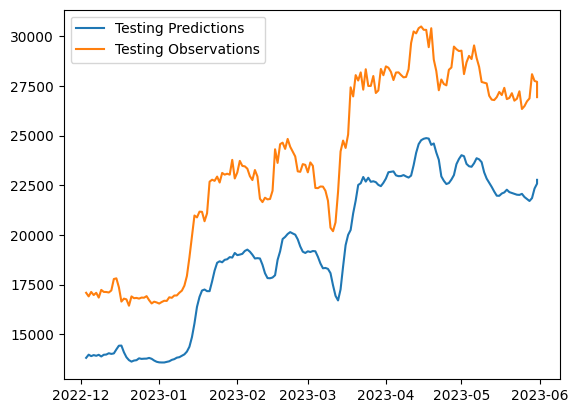

In [70]:
test_predictions = model.predict(X_test).flatten()

plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Testing Predictions', 'Testing Observations'])

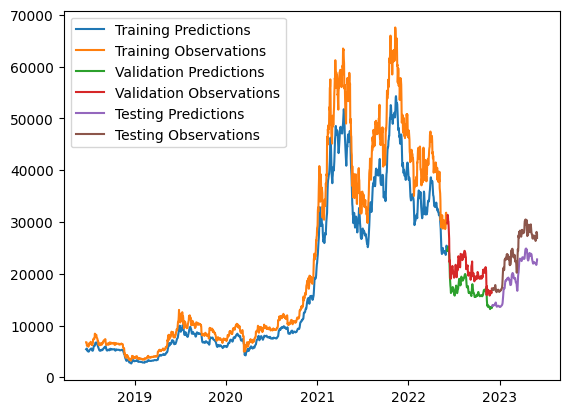

In [71]:
plt.plot(dates_train, train_predictions)
plt.plot(dates_train, y_train)
plt.plot(dates_val, val_predictions)
plt.plot(dates_val, y_val)
plt.plot(dates_test, test_predictions)
plt.plot(dates_test, y_test)
plt.legend(['Training Predictions', 
            'Training Observations',
            'Validation Predictions', 
            'Validation Observations',
            'Testing Predictions', 
            'Testing Observations'])

In [129]:
nextd = windowed_df.to_numpy()[-1,2:].reshape((3, 1))

nextd = nextd.astype(np.float32)

model.predict(np.array([nextd])).flatten()[0]

1/1 [==============================] - 0s 75ms/step


22434.836

In [133]:
data.index[-1]+dt.timedelta(days=1)

Timestamp('2023-06-01 00:00:00')

In [140]:
(1-np.abs(test_predictions-y_test)/y_test).mean()

0.8147441